<img src='../img/joint_school_banner_2.png' alt='Training school and workshop on fire' align='center' width='100%'></img>

<br>

<hr>

# CEMS GEFF Fire Weather Index

### About

The <a href='https://www.ecmwf.int/' target='_blank'>European Centre for Medium-Range Weather Forecasts (ECMWF)</a> produces daily fire danger forecasts and reanalysis products for the <a href='https://emergency.copernicus.eu/' target='_blank'>Copernicus Emergency Management Services (CEMS)</a>. The modelling system that generates the fire data products is called <a href='https://git.ecmwf.int//projects/CEMSF/repos/geff/browse' target='_blank'>Global ECMWF Fire Forecast (GEFF)</a> and it is based on the Canadian Fire Weather index as well as the US and Australian fire danger systems. 

In most European countries, the core of the wildfire season starts on 1st of March and ends on 31st of October.
The EFFIS network adopts the Canadian Forest Fire Weather Index (FWI) System as the method to assess the fire danger level in a harmonized way throughout Europe.
  
**European** Fire Danger Classes (FWI ranges, upper bound excluded):
  - Very low = 0 - 5.2
  - Low = 5.2 - 11.2 
  - Moderate = 11.2 - 21.3 
  - High = 21.3 - 38.0 
  - Very high = 38.0 - 50.0 
  - Extreme > 50.0

This notebook shows the structure of CEMS GEFF `Fire Weather Index` data and what information of the data files can be used in order to load, browse and visualize the data. 

The events featured in this notebook are the wildfires in Italy and Greece in summer 2021. 

### Basic Facts

> **Spatial resolution**: `~10km`<br>
> **Spatial coverage**: `Europe` <br>
> **Time steps**: `Daily, seasonal and annual` <br>
> **Data availability**: `since 1970`


### How to access the data

The fire weather index data can be ordered via the Copernicus <a href='https://doi.org/10.24381/cds.ca755de7' target='_blank'>Climate Data Store</a> and are distributed in `NetCDF` format.

You need to <a href='https://cds.climate.copernicus.eu/user/register' target='_blank'>register for an account</a> before being able to download data.

<hr>

##### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

%matplotlib inline

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id="load_fwi"></a>1. Load and browse GEFF Fire Weather Index data

As a first step, you can load one dataset with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data consists of a three dimensional data array, with `time`, `longitude` and `latitude` as dimensions. 

In [3]:
ds = xr.open_dataset("../../../eodata/lps_fire/geff/ECMWF_FWI_FWI_20210805_1200_hr_v4.0_con.nc")
ds


<xarray.Dataset>
Dimensions:    (time: 1, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 2021-08-05T12:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    fwi        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   Fri Oct 29 01:05:30 2021: cdo -f nc4 -chname,f...
    institution:               European Centre for Medium-Range Weather Forec...
    cdo_openmp_thread_number:  8
    CDO:                       Climate Data Operators version 1.9.8 (https://...

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `fwi` is the fire weather index data we are interested in.

In [4]:
fwi = ds['fwi']
fwi

<xarray.DataArray 'fwi' (time: 1, latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2021-08-05T12:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    standard_name:  forest_fire_weather_index
    long_name:      Forest fire weather index
    units:          Numeric
    param:          5.4.2
    institution:    ECMWF

### <a id='shift_europe'></a>Bring longitude coordinates onto a [-180,180] grid

The longitude values are on a [0,360] grid instead of a [-180,180] grid. 

You can assign new values to coordinates in an `xarray.Dataset`. You can do so with the `assign_coords()` function, which you can apply onto a `xarray.Dataset`. With the code below, you shift your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [5]:
fwi_assigned = fwi.assign_coords(longitude=(((fwi.longitude + 180) % 360) - 180)).sortby('longitude')
fwi_assigned

<xarray.DataArray 'fwi' (time: 1, latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2021-08-05T12:00:00
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    standard_name:  forest_fire_weather_index
    long_name:      Forest fire weather index
    units:          Numeric
    param:          5.4.2
    institution:    ECMWF

## <a id="subset_fwi"></a>2. Create a geographical subset around Italy and Greece

Let's subset our data to Italy and Greece.

For geographical subsetting, you can make use of the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [6]:
?generate_geographical_subset

Signature:
generate_geographical_subset(
    xarray,
    latmin,
    latmax,
    lonmin,
    lonmax,
    reassign=False,
)
Docstring:
Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
from a 0-360 to a -180 to 180 deg grid.

Parameters:
    xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
    latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
    reassign(boolean): default is False
    
Returns:
    Geographical subset of a xarray.DataArray.
File:      /tmp/ipykernel_267/3979307327.py
Type:      function


Define the bounding box information for Italy and Greece.

In [7]:
lonmin=10
lonmax=30
latmin=35
latmax=45

Now, let us apply the function [generate_geographical_subset](./functions.ipynb#generate_geographcial_subset) to subset the `fwi_assigned` xarray.DataArray. Let us call the new xarray.DataArray `fwi_subset`.

In [8]:
fwi_subset = generate_geographical_subset(xarray=fwi_assigned, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
fwi_subset

<xarray.DataArray 'fwi' (time: 1, latitude: 39, longitude: 79)>
array([[[10.799805 , 17.420248 , 24.36914  , ..., 20.979492 ,
         17.09733  , 16.54248  ],
        [11.998047 , 13.001953 , 16.319662 , ...,        nan,
                nan,        nan],
        [ 0.6582031,  1.8463541,  5.5240884, ...,        nan,
                nan,        nan],
        ...,
        [56.391113 , 60.751465 , 63.10669  , ...,        nan,
                nan,        nan],
        [58.073242 , 59.086914 , 62.18506  , ...,        nan,
                nan,        nan],
        [57.010254 , 58.53308  , 61.454346 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-08-05T12:00:00
  * longitude  (longitude) float32 10.25 10.5 10.75 11.0 ... 29.25 29.5 29.75
  * latitude   (latitude) float32 44.75 44.5 44.25 44.0 ... 35.75 35.5 35.25
Attributes:
    standard_name:  forest_fire_weather_index
    long_name:      Forest fire weather index
    units:          Numeric
    param:          5.4.2
    institution:    ECMWF

## <a id="vis_fwi"></a>3. Visualise GEFF Fire Weather Index data

Finally, you can visualise the fire weather index data by plotting it.

The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, borders and a grid**: specify additional features to be added to the plot
* **Plotting function**: specify the extent and plot the data with the `.plot`
* **Set plot title**: specify title of the plot

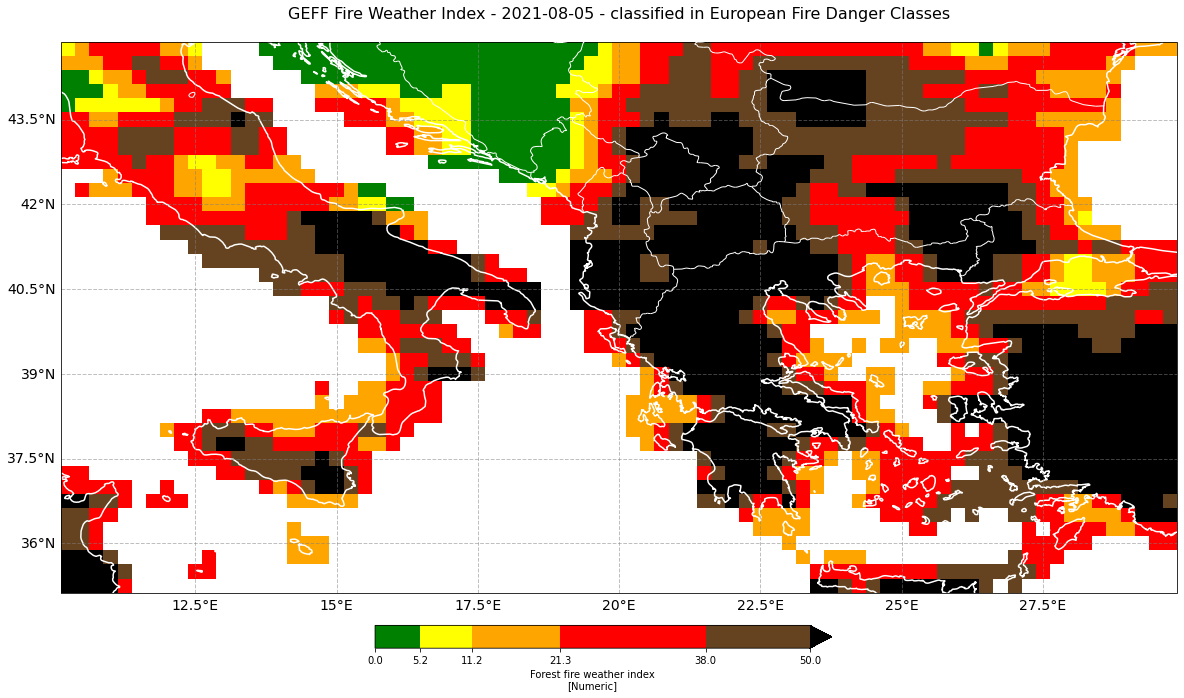

In [9]:
# Initiate a matplotlib figure
fig=plt.figure(figsize=(20,12))
ax=plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Specify coastlines and borders
ax.coastlines(color='white',linewidth=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=1, zorder=3)

# Specify a grid
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plotting function
fwi_subset.plot(levels = [0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
               colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
               label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'],
                  ax=ax,
               cbar_kwargs={'spacing':'proportional',
                           'ticks':[0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
                            'fraction':0.035,
                            'pad':0.05,
                           'orientation':'horizontal'})

# Set plot title
ax.set_title('GEFF Fire Weather Index - ' + str(fwi_subset.time.data)[2:12] + ' - classified in European Fire Danger Classes\n', size=16)

# Show the plot
plt.show()

**Return to the chapter:**
- [Surface impacts of wildfires](./01_surface_intro.ipynb#geff_fwi)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.